In [75]:
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import warnings; warnings.filterwarnings("ignore")

In [76]:
# Database connection parameters
conn_params = {
    'dbname': 'exec_condo_db',
    'user': 'postgres',
    'password': '********',
    'host': '127.0.0.1',
    'port': '5432'
}

# Establish connection to the database
conn = psycopg2.connect(**conn_params)

# Retrieve data from the transactions table
query_transactions = "SELECT * FROM transactions;"
transactions_df = pd.read_sql(query_transactions, conn)

# Retrieve data from the transaction_details table
query_transaction_details = "SELECT * FROM transaction_details;"
transaction_details_df = pd.read_sql(query_transaction_details, conn)

# Close the database connection
conn.close()

# Merge the dataframes on a common column (e.g., transaction_id)
df = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transaction_id')


In [77]:
df.head()

,id_x,street,x,y,project,market_segment,id_y,transaction_id,area,floor_range,no_of_units,contract_date,type_of_sale,price,property_type,district,type_of_area,tenure
0,2,NEO PEE TECK LANE,20914.198897,30589.107079,LANDED HOUSING DEVELOPMENT,RCR,4,2,159.3,-,1,0320,3,2630000.0,Terrace,05,Land,Freehold
1,2,NEO PEE TECK LANE,20914.198897,30589.107079,LANDED HOUSING DEVELOPMENT,RCR,5,2,186.0,-,1,0321,3,1880000.0,Strata Terrace,05,Strata,Freehold
2,2,NEO PEE TECK LANE,20914.198897,30589.107079,LANDED HOUSING DEVELOPMENT,RCR,6,2,257.0,-,1,0522,3,4600000.0,Terrace,05,Land,Freehold
3,3,ZEHNDER ROAD,NaN,NaN,LANDED HOUSING DEVELOPMENT,RCR,7,3,228.4,-,1,0724,3,5188888.0,Semi-detached,05,Land,Freehold
4,3,ZEHNDER ROAD,NaN,NaN,LANDED HOUSING DEVELOPMENT,RCR,8,3,524.3,-,1,0220,3,5500000.0,Semi-detached,05,Land,Freehold


In [78]:
df.shape

(44682, 18)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44682 entries, 0 to 44681
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_x            44682 non-null  int64  
 1   street          44682 non-null  object 
 2   x               44040 non-null  float64
 3   y               44040 non-null  float64
 4   project         44682 non-null  object 
 5   market_segment  44682 non-null  object 
 6   id_y            44682 non-null  int64  
 7   transaction_id  44682 non-null  int64  
 8   area            44682 non-null  float64
 9   floor_range     44682 non-null  object 
 10  no_of_units     44682 non-null  int64  
 11  contract_date   44682 non-null  object 
 12  type_of_sale    44682 non-null  object 
 13  price           44682 non-null  float64
 14  property_type   44682 non-null  object 
 15  district        44682 non-null  object 
 16  type_of_area    44682 non-null  object 
 17  tenure          44682 non-null 

In [80]:
df.describe()

,id_x,x,y,id_y,transaction_id,area,no_of_units,price
count,44682.000000,44040.000000,44040.000000,44682.000000,44682.000000,44682.000000,44682.000000,4.468200e+04
mean,291.975471,24864.848220,30585.136211,22344.500000,291.975471,100.050235,1.013786,1.997034e+06
std,158.166170,3912.502881,1938.613587,12898.726701,158.166170,252.025276,1.384768,3.193730e+06
min,2.000000,19027.871530,24528.350538,4.000000,2.000000,30.000000,1.000000,4.650000e+05
25%,142.000000,20628.928431,29259.728611,11174.250000,142.000000,62.000000,1.000000,1.238000e+06
50%,287.500000,24800.931590,30394.289680,22344.500000,287.500000,82.000000,1.000000,1.616400e+06
75%,428.000000,28696.696350,32314.265679,33514.750000,428.000000,113.000000,1.000000,2.200000e+06
max,573.000000,33093.909000,38161.986070,44685.000000,573.000000,32931.000000,193.000000,3.710000e+08


In [81]:
df.isna().sum()

id_x                0
street              0
x                 642
y                 642
project             0
market_segment      0
id_y                0
transaction_id      0
area                0
floor_range         0
no_of_units         0
contract_date       0
type_of_sale        0
price               0
property_type       0
district            0
type_of_area        0
tenure              0
dtype: int64

In [82]:
#Initial cleaning
df = df.drop(columns=['id_x', 'id_y'])

In [83]:
#Drop the null rows
df = df.dropna(axis=0, how='any')

In [84]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

In [85]:
categorical_columns

Index(['street', 'project', 'market_segment', 'floor_range', 'contract_date',
       'type_of_sale', 'property_type', 'district', 'type_of_area', 'tenure'],
      dtype='object')

In [86]:
numerical_columns

Index(['x', 'y', 'transaction_id', 'area', 'no_of_units', 'price'], dtype='object')

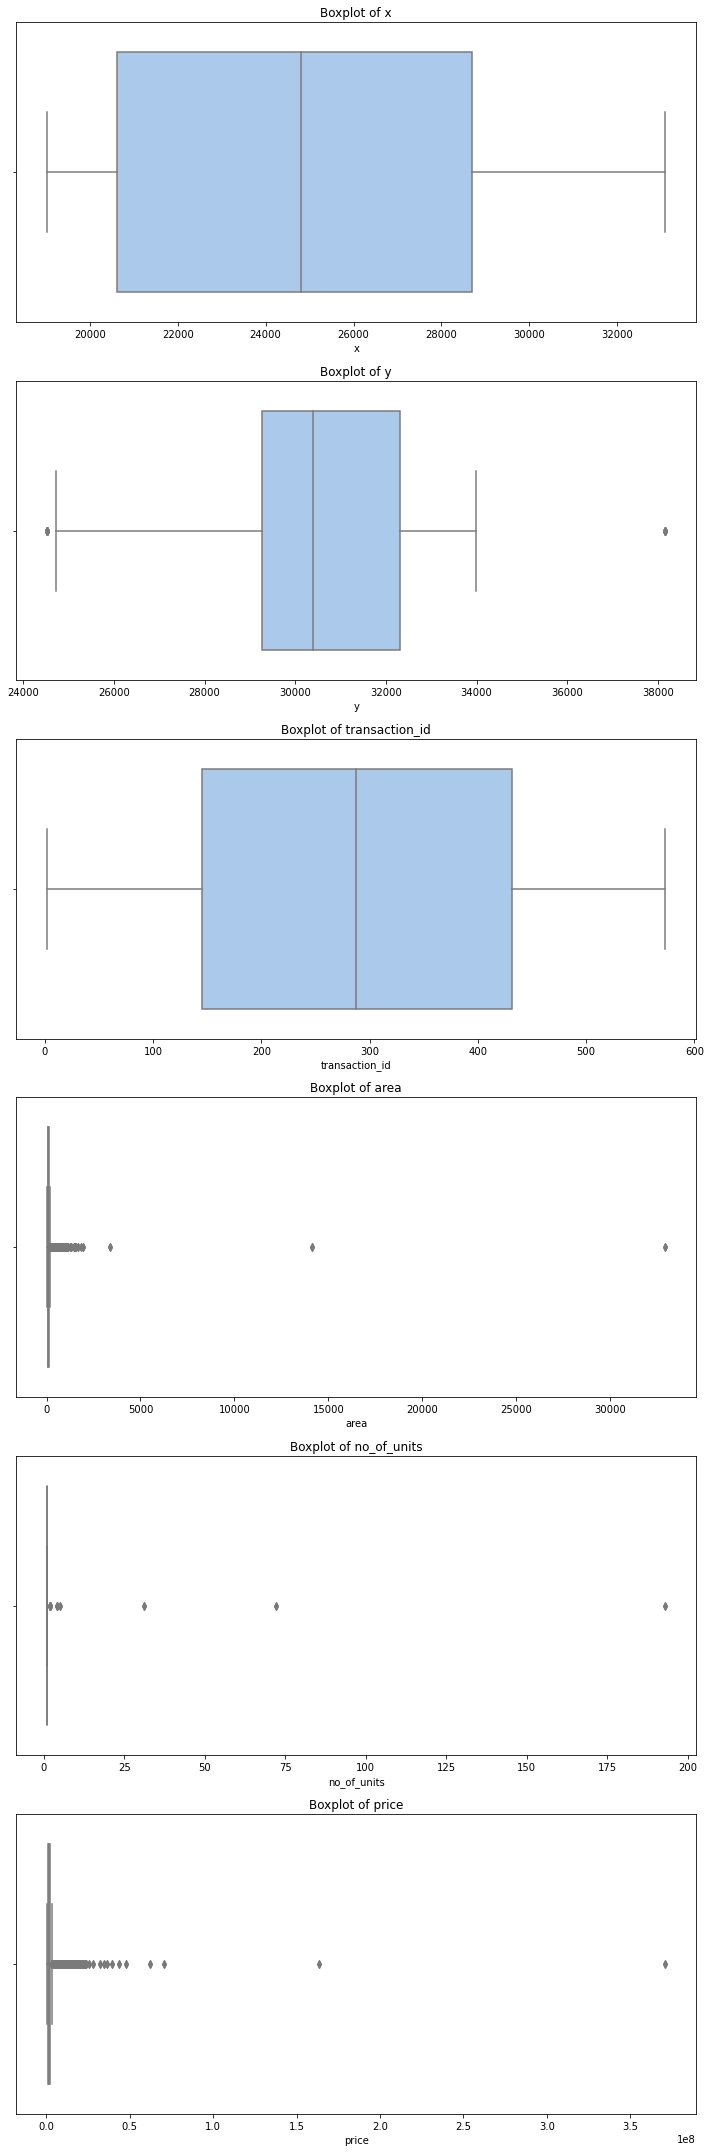

In [87]:
# Plot boxplots to visualize potential outliers
plt.figure(figsize=(10, len(numerical_columns) * 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(x=df[col], palette="pastel")
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

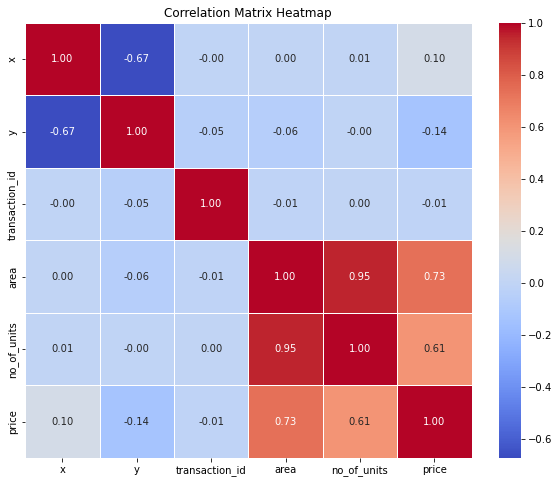

In [88]:
# Select only the numerical columns
numerical_data = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of numerical columns
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [89]:
df = df[df['property_type'] == 'Condominium']

In [90]:
# Define a function to extract the lease start date, total lease period, and calculate remaining lease
def parse_tenure(tenure):
    # Default values
    lease_start_date = None
    total_lease_period = None
    remaining_lease = None
    
    # Check if tenure is 'Freehold'
    if 'Freehold' in tenure:
        total_lease_period = None  
        remaining_lease = None  
    else:
        # Extract lease period and start date using regex
        match = re.search(r'(\d+) yrs lease commencing from (\d+)', tenure)
        if match:
            total_lease_period = int(match.group(1))
            lease_start_date = int(match.group(2))
            remaining_lease = total_lease_period - (pd.Timestamp.now().year - lease_start_date)
    
    return pd.Series([lease_start_date, total_lease_period, remaining_lease])

# Apply the function to the tenure column
df[['lease_start_date', 'total_lease_period', 'remaining_lease']] = df['tenure'].apply(parse_tenure)

# Encode 'tenure'
# 1 for Freehold, 0 for leasehold
df['tenure_encoded'] = df['tenure'].apply(lambda x: 1 if 'Freehold' in x else 0)
df = df[df['tenure_encoded'] != 1]

In [91]:
# Define the function to decode contract_date
def decode_contract_date(date_str):
    if isinstance(date_str, pd.Timestamp):
        return date_str
    elif pd.isna(date_str):
        return pd.NaT
    else:
        # Extract the month and year from the string
        month = date_str[:2]  # First two characters represent the month
        year = '20' + date_str[2:]  # Last two characters represent the year, prefixed with '20'
        return pd.to_datetime(f'{year}-{month}', format='%Y-%m')

# Convert 'contract_date' to datetime
df['contract_date'] = df['contract_date'].apply(decode_contract_date)

# Extract the year and quarter into separate columns
df['contract_year'] = df['contract_date'].dt.year
df['contract_quarter'] = df['contract_date'].dt.quarter

In [92]:
df = df.drop(columns=['street','project','transaction_id','contract_date','tenure'])

In [93]:
df['floor_range'].value_counts()

01-05    3674
06-10    2530
11-15    1382
16-20    1044
21-25     692
26-30     556
31-35     510
36-40     338
41-45     148
46-50      16
51-55       8
56-60       4
Name: floor_range, dtype: int64

In [94]:
df = df[df['floor_range'] != '-']

In [95]:
# Define categorization logic based on the provided floor ranges
def categorize_floor(level):
    if 'B' in level:
        return 'basement'
    elif level in ['01-05', '06-10']:
        return 'low_floor'
    elif level in ['11-15', '16-20', '21-25', '26-30', '31-35', '36-40']:
        return 'mid_floor'
    elif level in ['41-45', '46-50', '51-55', '56-60']:
        return 'high_floor'
    else:
        return 'other'

# Apply categorization to the 'floor_range' column
df['floor_category'] = df['floor_range'].map(categorize_floor)


In [96]:
df = df.drop(columns=['floor_range','property_type','type_of_area'])

In [97]:
df['type_of_sale'] = df['type_of_sale'].astype(int)
# Create a mapping dictionary
sale_type_mapping = {
    1: 'New Sale',
    2: 'Sub Sale',
    3: 'Resale'
}

# Replace the values in the 'type_of_sale' column using the mapping
df['type_of_sale'] = df['type_of_sale'].map(sale_type_mapping)

In [98]:
df_1 = pd.get_dummies(df, columns=['market_segment','type_of_sale','district','floor_category'])

In [99]:
df_1

,x,y,area,no_of_units,price,lease_start_date,total_lease_period,remaining_lease,tenure_encoded,contract_year,...,type_of_sale_New Sale,type_of_sale_Resale,type_of_sale_Sub Sale,district_01,district_03,district_04,district_05,floor_category_high_floor,floor_category_low_floor,floor_category_mid_floor
6,28382.47067,25008.33592,201.0,1,3000000.0,2007.0,99.0,82.0,0,2024,...,0,1,0,0,0,1,0,0,1,0
7,28382.47067,25008.33592,249.0,1,4610000.0,2007.0,99.0,82.0,0,2023,...,0,1,0,0,0,1,0,0,1,0
8,28382.47067,25008.33592,238.0,1,4397000.0,2007.0,99.0,82.0,0,2024,...,0,1,0,0,0,1,0,0,1,0
9,28382.47067,25008.33592,194.0,1,2800000.0,2007.0,99.0,82.0,0,2020,...,0,1,0,0,0,1,0,0,1,0
10,28382.47067,25008.33592,194.0,1,3180000.0,2007.0,99.0,82.0,0,2020,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44677,19547.85969,33943.45546,161.0,1,2050000.0,1996.0,99.0,71.0,0,2023,...,0,1,0,0,0,0,1,0,1,0
44678,19547.85969,33943.45546,94.0,1,1150000.0,1996.0,99.0,71.0,0,2023,...,0,1,0,0,0,0,1,0,1,0
44679,19547.85969,33943.45546,96.0,1,1080000.0,1996.0,99.0,71.0,0,2022,...,0,1,0,0,0,0,1,0,1,0
44680,19547.85969,33943.45546,110.0,1,1230000.0,1996.0,99.0,71.0,0,2023,...,0,1,0,0,0,0,1,0,1,0


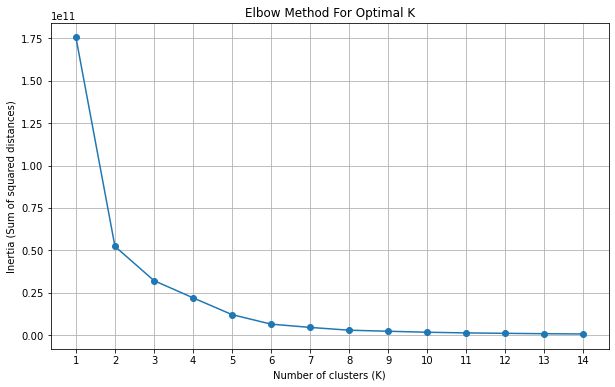

In [100]:
# Range of K values to try
k_values = range(1, 15)
inertia_values = []

# Calculate inertia for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_1[['x', 'y']])
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters (K)
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [109]:
kmeans = KMeans(n_clusters=7)
df_1['location_cluster']=kmeans.fit_predict(df_1[['x','y']])

# Group the data by 'location_cluster' and display X, Y coordinates
for cluster in sorted(df_1['location_cluster'].unique()):
    cluster_data = df_1[df_1['location_cluster'] == cluster][['x', 'y']]
    print(f"Cluster {cluster}:\n", cluster_data.head(), "\n")

Cluster 0:
                 x           y
1724  27042.14738  28096.3676
1725  27042.14738  28096.3676
1726  27042.14738  28096.3676
1727  27042.14738  28096.3676
1728  27042.14738  28096.3676 

Cluster 1:
                 x            y
1663  19424.17318  33280.65333
1664  19424.17318  33280.65333
1665  19424.17318  33280.65333
1666  19424.17318  33280.65333
1667  19424.17318  33280.65333 

Cluster 2:
                x            y
324  30095.03618  29199.57054
325  30095.03618  29199.57054
326  30095.03618  29199.57054
327  30095.03618  29199.57054
328  30095.03618  29199.57054 

Cluster 3:
                 x           y
2655  25073.21159  30746.7066
2656  25073.21159  30746.7066
2657  25073.21159  30746.7066
2658  25073.21159  30746.7066
2659  25073.21159  30746.7066 

Cluster 4:
               x            y
6   28382.47067  25008.33592
7   28382.47067  25008.33592
8   28382.47067  25008.33592
9   28382.47067  25008.33592
10  28382.47067  25008.33592 

Cluster 5:
                 x 

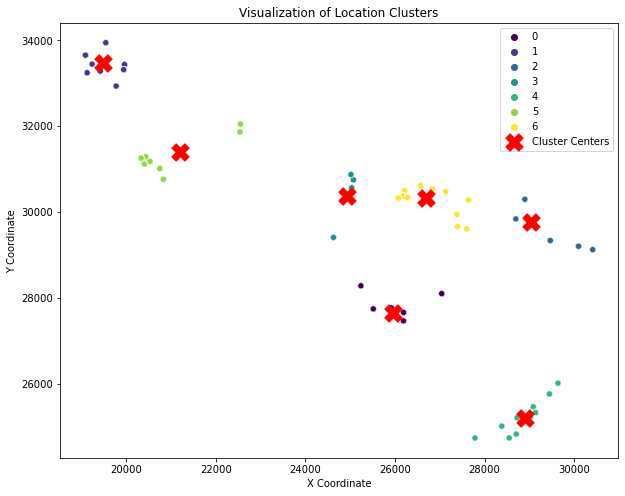

In [110]:
# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='location_cluster', palette='viridis', data=df_1, legend='full')

# Plot the cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', marker='X', label='Cluster Centers')

plt.title('Visualization of Location Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [111]:
df_1 = df_1.drop(columns=['x','y'])

In [112]:
df_1

,area,no_of_units,price,lease_start_date,total_lease_period,remaining_lease,tenure_encoded,contract_year,contract_quarter,market_segment_CCR,...,type_of_sale_Resale,type_of_sale_Sub Sale,district_01,district_03,district_04,district_05,floor_category_high_floor,floor_category_low_floor,floor_category_mid_floor,location_cluster
6,201.0,1,3000000.0,2007.0,99.0,82.0,0,2024,1,1,...,1,0,0,0,1,0,0,1,0,4
7,249.0,1,4610000.0,2007.0,99.0,82.0,0,2023,4,1,...,1,0,0,0,1,0,0,1,0,4
8,238.0,1,4397000.0,2007.0,99.0,82.0,0,2024,2,1,...,1,0,0,0,1,0,0,1,0,4
9,194.0,1,2800000.0,2007.0,99.0,82.0,0,2020,1,1,...,1,0,0,0,1,0,0,1,0,4
10,194.0,1,3180000.0,2007.0,99.0,82.0,0,2020,4,1,...,1,0,0,0,1,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44677,161.0,1,2050000.0,1996.0,99.0,71.0,0,2023,1,0,...,1,0,0,0,0,1,0,1,0,1
44678,94.0,1,1150000.0,1996.0,99.0,71.0,0,2023,1,0,...,1,0,0,0,0,1,0,1,0,1
44679,96.0,1,1080000.0,1996.0,99.0,71.0,0,2022,3,0,...,1,0,0,0,0,1,0,1,0,1
44680,110.0,1,1230000.0,1996.0,99.0,71.0,0,2023,3,0,...,1,0,0,0,0,1,0,1,0,1


In [113]:
# Define features and target for training
features = df_1.drop(columns=['price'])
target = df_1['price']

# Train a RandomForest model to compute feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                      Feature  Importance
0                        area    0.819474
2            lease_start_date    0.053439
4             remaining_lease    0.033109
6               contract_year    0.026002
17                district_05    0.019218
21           location_cluster    0.011635
8          market_segment_CCR    0.009612
7            contract_quarter    0.007525
19   floor_category_low_floor    0.004854
14                district_01    0.004805
20   floor_category_mid_floor    0.002246
16                district_04    0.001930
10         market_segment_RCR    0.001899
18  floor_category_high_floor    0.001581
9          market_segment_OCR    0.001048
15                district_03    0.000729
11      type_of_sale_New Sale    0.000593
12        type_of_sale_Resale    0.000221
3          total_lease_period    0.000066
13      type_of_sale_Sub Sale    0.000014
5              tenure_encoded    0.000000
1                 no_of_units    0.000000


In [115]:
top_features = feature_importance_df['Feature'].head(5).tolist()

In [116]:
top_features 

['area', 'lease_start_date', 'remaining_lease', 'contract_year', 'district_05']

In [117]:
df_1['year_5'] = df_1['lease_start_date'] + 5
df_1['year_10'] = df_1['lease_start_date'] + 10

In [118]:
df_5_years = df_1[df_1['contract_year'] == df_1['year_5']]
df_10_years = df_1[df_1['contract_year'] == df_1['year_10']]

In [119]:
# Define features and target for 5-year prediction
X_5 = df_5_years[top_features]
y_5 = df_5_years['price']

# Define features and target for 10-year prediction
X_10 = df_10_years[top_features]
y_10 = df_10_years['price']

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)


In [120]:
# Train the RandomForest model for 5-year prediction
model_5_years = RandomForestRegressor(n_estimators=100, random_state=42)
model_5_years.fit(X_train_5, y_train_5)

# Train the RandomForest model for 10-year prediction
model_10_years = RandomForestRegressor(n_estimators=100, random_state=42)
model_10_years.fit(X_train_10, y_train_10)

RandomForestRegressor(random_state=42)

In [121]:
# Predict on the test set for 5-year model
y_pred_5 = model_5_years.predict(X_test_5)

# Predict on the test set for 10-year model
y_pred_10 = model_10_years.predict(X_test_10)

# Calculate evaluation metrics for 5-year prediction
rmse_5 = mean_squared_error(y_test_5, y_pred_5, squared=False)
mae_5 = mean_absolute_error(y_test_5, y_pred_5)
r2_5 = r2_score(y_test_5, y_pred_5)

print(f'5-Year Prediction Model: RMSE={rmse_5}, MAE={mae_5}, R^2={r2_5}')

# Calculate evaluation metrics for 10-year prediction
rmse_10 = mean_squared_error(y_test_10, y_pred_10, squared=False)
mae_10 = mean_absolute_error(y_test_10, y_pred_10)
r2_10 = r2_score(y_test_10, y_pred_10)

print(f'10-Year Prediction Model: RMSE={rmse_10}, MAE={mae_10}, R^2={r2_10}')


5-Year Prediction Model: RMSE=87377.77745444461, MAE=52631.40908298046, R^2=0.9901017104986898
10-Year Prediction Model: RMSE=78780.67843085676, MAE=57563.38771793082, R^2=0.9847288851691741


In [122]:
# Predict future prices using the trained models
df_1['predicted_price_5_years'] = model_5_years.predict(df_1[top_features])
df_1['predicted_price_10_years'] = model_10_years.predict(df_1[top_features])

In [123]:
df_1

,area,no_of_units,price,lease_start_date,total_lease_period,remaining_lease,tenure_encoded,contract_year,contract_quarter,market_segment_CCR,...,district_04,district_05,floor_category_high_floor,floor_category_low_floor,floor_category_mid_floor,location_cluster,year_5,year_10,predicted_price_5_years,predicted_price_10_years
6,201.0,1,3000000.0,2007.0,99.0,82.0,0,2024,1,1,...,1,0,0,1,0,4,2012.0,2017.0,3.277805e+06,3.104726e+06
7,249.0,1,4610000.0,2007.0,99.0,82.0,0,2023,4,1,...,1,0,0,1,0,4,2012.0,2017.0,3.277805e+06,3.224478e+06
8,238.0,1,4397000.0,2007.0,99.0,82.0,0,2024,2,1,...,1,0,0,1,0,4,2012.0,2017.0,3.277805e+06,3.227726e+06
9,194.0,1,2800000.0,2007.0,99.0,82.0,0,2020,1,1,...,1,0,0,1,0,4,2012.0,2017.0,3.277805e+06,2.703218e+06
10,194.0,1,3180000.0,2007.0,99.0,82.0,0,2020,4,1,...,1,0,0,1,0,4,2012.0,2017.0,3.277805e+06,2.703218e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44677,161.0,1,2050000.0,1996.0,99.0,71.0,0,2023,1,0,...,0,1,0,1,0,1,2001.0,2006.0,1.886447e+06,2.375168e+06
44678,94.0,1,1150000.0,1996.0,99.0,71.0,0,2023,1,0,...,0,1,0,1,0,1,2001.0,2006.0,1.475528e+06,1.780900e+06
44679,96.0,1,1080000.0,1996.0,99.0,71.0,0,2022,3,0,...,0,1,0,1,0,1,2001.0,2006.0,1.483540e+06,1.688858e+06
44680,110.0,1,1230000.0,1996.0,99.0,71.0,0,2023,3,0,...,0,1,0,1,0,1,2001.0,2006.0,1.586182e+06,1.773989e+06


In [142]:
# # Create a dictionary with the input data
# input_data = {
#     'area': [120.0],  
#     'lease_start_date': [2015],
#     'remaining_lease':[93],
#     'contract_year': [2021],
#     'district_05' :[1], 
# }

# # Convert the dictionary to a DataFrame
# test_input = pd.DataFrame(input_data)

In [140]:
predicted_price_5 = model_5_years.predict(test_input)
predicted_price_5

array([1586181.74891775])

In [141]:
predicted_price_10 = model_10_years.predict(test_input)
predicted_price_10

array([2089009.69474969])

In [145]:
#import pickle

#with open('model_5_years.pkl', 'wb') as file:
#    pickle.dump(model_5_years, file)


In [146]:
#with open('model_10_years.pkl', 'wb') as file:
#    pickle.dump(model_10_years, file)